<center><img src="Fig/UGA.png" width="30%" height="30%"></center>
<center><h3>Master of Science in Industrial and Applied Mathematics (MSIAM)  -- 1st year</h3></center>
<hr>
<center><h1>Numerical Optimization</h1></center>
<center><h2>Lab 9: constrained optimization, basics</h2></center>

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np

from plotLib import *
%matplotlib inline

---

# Problem

We consider the problem of miniizing a function $f$ under inequality constraints:

\begin{equation}
\min_{x\in\mathbb R^n} f(x) \qquad \text{s.t.}\qquad c_i(x)\le 0, \quad i=1, \ldots, m.
\label{eq:gereral_problem} \tag{1}
\end{equation}

Note that this setting also encompasses equality constraints.

### Simple feasible sets
In previous labs, we discussed the projected gradient method, which allowed to tackle problems where the feasible set defined by the constraints could be easily projected upon. These sets were mainly $\mathbb R^+$, $[a, b]$ or products of such sets. The algorithm wrote

\begin{equation}
    x_{k+1} = \mathrm{proj}_{C} (x_k - \gamma \nabla f(x_k))
\end{equation}

where $C = \{x : c_i(x)\le 0, \quad i=1, \ldots, m\}$.

### Generic feasible sets: primal and dual problem

#### Primal problem
We now turn to the more genral problem $\eqref{eq:gereral_problem}$, and introduce its so-called *primal problem*:

\begin{equation}
\min_{x\in\mathbb R^n} \max_{\lambda \in\mathbb{R}_{-}^m} f(x) + \langle \lambda, c(x) \rangle
\label{eq:primal} \tag{$\mathcal P$}
\end{equation}

> **Task 1**: Compare problems $\eqref{eq:gereral_problem}$ and $\eqref{eq:primal}$. You may consider the function $p$ defined by:

\begin{equation}
p(x) = \max_{\lambda \in\mathbb{R}_{-}^m} f(x) + \langle \lambda, c(x) \rangle.
\end{equation}

#### Dual problem
One may also consider the so-called *dual problem*:

\begin{equation}
\max_{\lambda \in\mathbb{R}_{-}^m} \min_{x\in\mathbb R^n} f(x) + \langle \lambda, c(x) \rangle,
\label{eq:dual} \tag{$\mathcal D$}
\end{equation}

and define the *dual function*

\begin{equation}
q(\lambda) = \min_{x\in\mathbb R^n} f(x) + \langle \lambda, c(x) \rangle.
\end{equation}

You may recognize here the basic objects on which the duality theory builds, including the Langrangian function of $\eqref{eq:gereral_problem}$:

$$L(x, \lambda) = f(x) + \langle \lambda, c(x)\rangle .$$

Under suitable assumptions, all solutions $(\bar{x}, \bar{\lambda})$ of problem $\eqref{eq:primal}$ are solutions of problem $\eqref{eq:dual}$, and in particular, $\bar{x}$ is a solution of problem $\eqref{eq:gereral_problem}$. The problems considerd in this lab all fall into this well-behaved category.

#### Solving the dual
The projected gradient attempts to solve $\eqref{eq:primal}$ directly, which makes it a *primal method*. We consider *dual methods*, designed to solve $\eqref{eq:dual}$. In doing so, we trade the problem of minimizing an explicit function on a difficult set by that of minimizing a complex function (defined as a minimization) on a simple set.

_Fact_: Let $\lambda\in\mathbb R^m$ such that a solution to $\min_{x\in\mathbb R^n} f(x) + \langle \lambda, c(x) \rangle$ exists, which we denote $\bar{x}_\lambda$. If $\bar{x}_\lambda$ is the unique solution of this problem, then

\begin{cases} 
q(\lambda ) = f(\bar{x}_\lambda) + \langle \lambda, c(\bar{x}_\lambda) \rangle \\
\nabla q(\lambda ) = c(\bar{x}_\lambda)
\end{cases}

> **Task 2**: What algorithm could be employed to solve $\eqref{eq:dual}$?

The goal of this lab is to implement this algorithm. We'll require a stopping criterion for that algorithm, and example problems.

## A simple problem

As a first problem, we consider:

\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & 4 (x_1-3)^2 + 2 (x_2-1)^2 \\
& \text{subject to}
& & x_1 - x_2 - 1 \le 0
\end{aligned}
\end{equation*}


> **Task 3**: implement the oracles in the next cell.

In [29]:
class SimplePb:
    def f(self, x):
        return 4*(x[0]-3)**2+2*(x[1]-1)**2

    def f_grad(self, x):
        # TODO
        return np.array([0, 0])

    def f_grad_hessian(self, x):
        # TODO
        g = np.array([0, 0])
        H = np.array([(0, 0), (0, 0)])
        return g, H

    def c1(self, x):
        return x[0] - x[1] - 1

    def c(self, x):
        return np.array([ c1(x)])

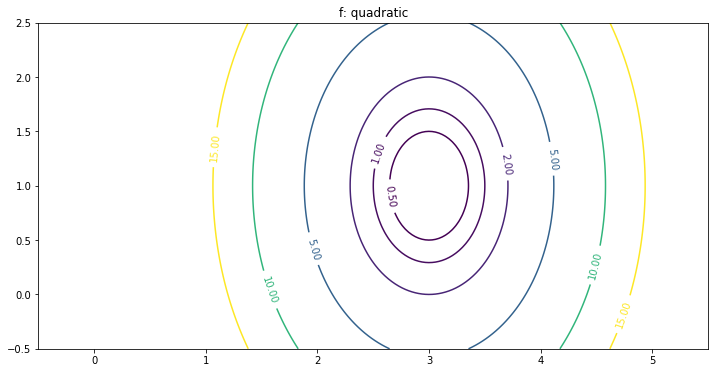

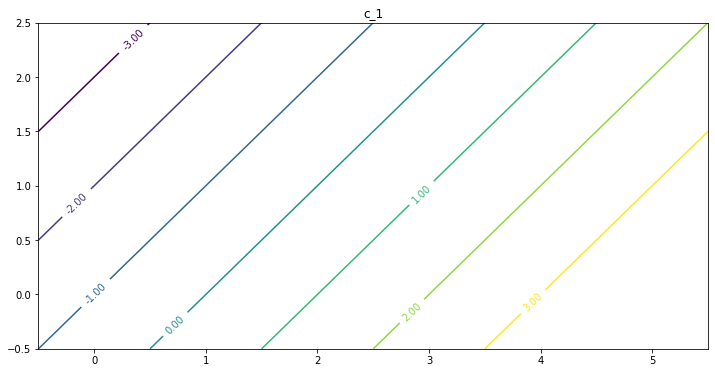

In [31]:
simplepb = SimplePb()

x1_min = -0.5
x1_max = 5.5
x2_min = -0.5
x2_max = 2.5
levels = [0.5,1,2,5,10,15]
level_plot(simplepb.f, x1_min, x1_max, x2_min, x2_max, 200, levels , 'f: quadratic' )

c1levels = [-3,-2,-1,0,1,2,3]
level_plot( simplepb.c1, x1_min, x1_max, x2_min, x2_max, 200, c1levels , 'c_1')

> **Task 4**: Given the graphs, what is the minimizer pair $(\bar{x}, \bar{\lambda})$ for this problem.

## A stopping criterion
The algorithm coming up will generate a sequence of iterates that should get close to a solution of the initial constrained problem. We seek to formulate a criterion which determines if a given point is a solution, up to some precision. To do so, we first need to formalise the notion of solution of the constrained problem, and determine what are the mathematical properties of such points.

> **Task 5**: 
> 1. How does one formalizes the notion of "solution" of the constrained problem?
> 2. What properties do these points all verify? In other words, how does the necessary conditions of optimality write?
> 3. What parts of these relations need to be relaxed when implementing numerically?

## The gradient ascent algorithm
The *gradient ascent* algorithm, also known as *Uzawa's algorithm* consists in the following iteration:

\begin{equation*}\left|
\begin{array}{l}
    x_{k+1} = \arg\min_{x\in\mathbb R^n} f(x) + \langle \lambda^k, c(x)\rangle \\ 
    \lambda_{k+1} = \mathrm{proj}_{\mathbb{R}_-^m}\left( \lambda^k + \gamma c(x_{k+1}) \right)
\end{array}\right.
\end{equation*}

where $\gamma>0$ is some chosen stepsize.

> **Task 6**: The frist part of the iteration consists in solving an otpimization problem. What kind of problem is it? What ways to solve it can you think of? Which is most relevant?

*Note*: You may find it useful for this task to peek at the problems considered next. Overall, there will be several cosntraints ($m>1$), but all individual constraints will be quadratic functions.

> **Task 7**: Implement the Uzawa algorithm as described above, and check it on the above toy problem.

*Note*: gradient ascent converges for any starting point, and for stepsizes $\gamma \in (0, 2\mu/\tau^2)$, where $\mu$ is a strong convexity constant for $f$ and $\tau$ a Lipschitz continuity constant for $c$.

## More involved problems

You may now experiment with your algorithm on more involved problems.

### 1. Two affine active constraints

We consider the problem

\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & 4 (x_1-4)^2 + 2 (x_2-1)^2 \\
& \text{subject to}
& & 2 x_1 - x_2 - 4 \le 0 \\
& & & x_1 - 3 \le 0
\end{aligned}
\end{equation*}

> **Task 8**: implement the oracles in the next cell.

In [64]:
class ActiveAffinePb:
    def f(self, x):
        return 4*(x[0]-4)**2+2*(x[1]-1)**2

    def f_grad(self, x):
        # TODO
        return np.array([0, 0])

    def f_grad_hessian(self, x):
        # TODO
        g = np.array([0, 0])
        H = np.array([(0, 0), (0, 0)])
        return g, H

    def c1(self, x):
        return 2*x[0] - x[1] - 4
    
    def c2(self, x):
        return x[0] - 3

    def c(self, x):
        return np.array([ c1(x), c2(x)])

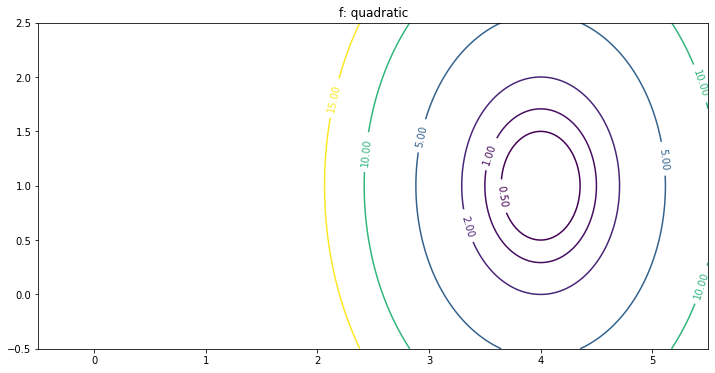

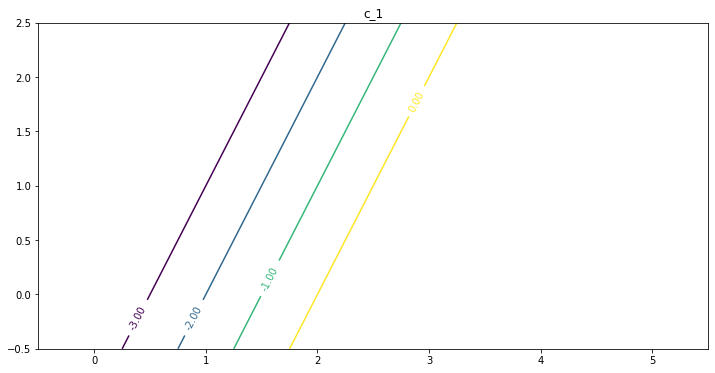

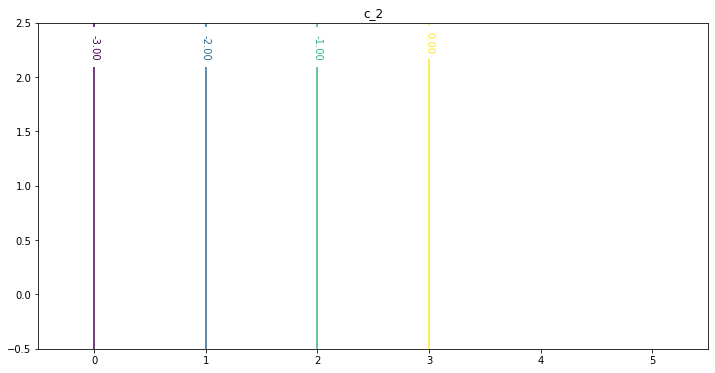

In [65]:
activeaffpb = ActiveAffinePb()

x1_min = -0.5
x1_max = 5.5
x2_min = -0.5
x2_max = 2.5
levels = [0.5,1,2,5,10,15]
level_plot(activeaffpb.f, x1_min, x1_max, x2_min, x2_max, 200, levels , 'f: quadratic' )

c1levels = [-3,-2,-1,0]
level_plot( activeaffpb.c1, x1_min, x1_max, x2_min, x2_max, 200, c1levels , 'c_1')
c2levels = [-3,-2,-1,0]
level_plot( activeaffpb.c2, x1_min, x1_max, x2_min, x2_max, 200, c2levels , 'c_2')

> **Task 9**: Run your algorithm on the above problem. Inspect the solution pair, and propose a geometrical interpretation of the KKT conditions. 

### 2. An ellipse constraint

We consider the problem

\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & 4 (x_1-4)^2 + 2 (x_2-1)^2 \\
& \text{subject to}
& & x_1 - x_2 - 1 \le 0
\end{aligned}
\end{equation*}

> **Task 8**: implement the oracles in the next cell.

In [71]:
class EllipseCstrPb:
    def f(self, x):
        return 4*(x[0]-4)**2+2*(x[1]-1)**2

    def f_grad(self, x):
        # TODO
        return np.array([0, 0])

    def f_grad_hessian(self, x):
        # TODO
        g = np.array([0, 0])
        H = np.array([(0, 0), (0, 0)])
        return g, H

    def c1(self, x):
        return 0.5 * (x[0] - 1)**2 + x[1]**2 - 1

    def c(self, x):
        return np.array([ c1(x) ])

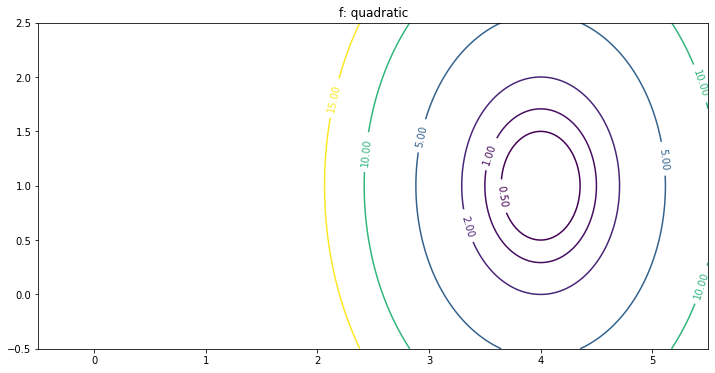

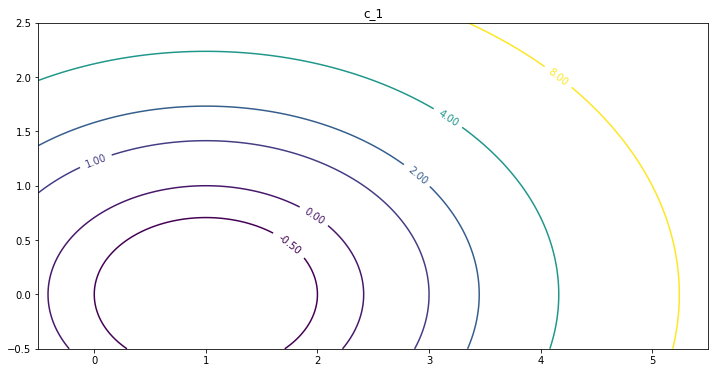

In [75]:
ellipsecstrpb = EllipseCstrPb()

x1_min = -0.5
x1_max = 5.5
x2_min = -0.5
x2_max = 2.5
levels = [0.5,1,2,5,10,15]
level_plot(ellipsecstrpb.f, x1_min, x1_max, x2_min, x2_max, 200, levels , 'f: quadratic' )

c1levels = [-0.5, 0, 1, 2, 4, 8]
level_plot( ellipsecstrpb.c1, x1_min, x1_max, x2_min, x2_max, 200, c1levels , 'c_1')

## Going further

- minimizing a full problem at each iteration is costly -> only one gradient step;
- towards second order and SQP?